<a href="https://colab.research.google.com/github/jp-ishimwe/Projects/blob/master/Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
!pip install transformers --upgrade
#!pip install transformers -q
#!pip install wandb -q
!pip install --upgrade wandb
!pip install dill -q

In [2]:
#@title Import packages { run: "auto", vertical-output: true, display-mode: "both" }
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random
import pandas as pd
import numpy as np
from collections import defaultdict
from sklearn.base import BaseEstimator, TransformerMixin
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
import pickle
import dill
import tarfile
import json, gzip

import wandb

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from transformers import T5Tokenizer, T5ForConditionalGeneration
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Ignore excessive warnings
import logging
logging.propagate = False 
logging.getLogger().setLevel(logging.ERROR)

import warnings
warnings.filterwarnings('ignore')

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
pwd

'/root/Projects'

In [4]:
#!cp '/root/optimizers.py' '/root/Projects/' # SSH
#!cp '/home/jupyter/optimizers.py' '/home/jupyter/Projects/' # for GCP
!cp '/content/drive/My Drive/Colab Notebooks/optimizers.py' .


from optimizers import AdaFactor

In [5]:
!nvidia-smi
!/usr/local/cuda/bin/nvcc --version

Thu Jul 23 12:50:12 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8    27W / 149W |     11MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [6]:
#@title To proceed should be cuda { run: "auto", vertical-output: true }
CUDA = torch.cuda.is_available()
device = torch.device("cuda" if CUDA else "cpu")
print(device)

cuda


In [ ]:
##!wandb login fac9119080ca108ca15c420ede645a5e6e79a07c

### First Log in 

In [7]:
!wandb login

wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice: 2
wandb: You chose 'Use an existing W&B account'
wandb: You can find your API key in your browser here: https://app.wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: You can find your API key in your browser here: https://app.wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter: fac9119080ca108ca15c420ede645a5e6e79a07c
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
Successfully logged in to Weights & Biases!


#### Getting dataset

You can find the dataset [here](http://lil.nlp.cornell.edu/newsroom/download/index.html)

**Loading data**

In [ ]:
# fname = '/content/drive/My Drive/Colab Notebooks/newsroom-release.tar'

# tar = tarfile.open(fname, "r:")
# tar.extractall()
# tar.close()

In [ ]:
!mv '/content/data/' '/content/drive/My Drive/Colab Notebooks'

In [ ]:
!cp -r '/content/release/' '/content/drive/My Drive/Colab Notebooks/data'

In [10]:
#path = '/home/jupyter/' # GCp
#path = '/root/release/' # SSH
path = "/content/drive/My Drive/Colab Notebooks/data/release/" # Colab

def read_data(path, name):
  data = []
  with gzip.open(path + name + ".jsonl.gz") as f: #+".jsonl.gz" with GCP
      for ln in f:
          obj = json.loads(ln)
          data.append(obj)
  return data

trainset = read_data(path, 'train') 
devset = read_data(path, 'dev')
#testset = read_data(path, 'test')

In [11]:
def get_data(data):
  data_dict = {'text': [], 'summary': []}
  for article in data:
    data_dict['text'].append(article['text'])
    data_dict['summary'].append(article['summary'])
  return pd.DataFrame(data_dict)

train_data = get_data(trainset)
valid_data = get_data(devset)
# test_data = get_data(testset)

In [12]:
train_data.head()

,text,summary
0,"HAMBURG, Germany, June 3  As he left the socc...",A surge in discriminatory behavior toward blac...
1,"WASHINGTON, Dec. 23 - The National Security Ag...","The volume of information harvested, without \..."
2,IF outsized executive pay has indeed become a ...,The battle between Pfizer Inc.'s investors and...
3,BY A.J. BENZA & MICHAEL LEWITTES\n\nIf Simon R...,"If Simon Rex looks a little familiar, it may n..."
4,Spinach has terrorized generations of veggie-p...,POPEYE-WORTHY PIE. PHYLLO DOUGH WRAPS SPINACH ...


In [13]:
print(f'The size of training dataset:{train_data.shape} | validation dataset: {valid_data.shape}')

The size of training dataset:(995041, 2) | validation dataset: (108837, 2)


In [14]:
contraction = {"isn't": "is not", "aren't": "are not","can't": "cannot", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you ll":"you will", "you'll've": "you will have",
                           "you're": "you are", "you re": "you are" , "you've": "you have"}

###### Checking for NA

In [15]:
train_data.isna().sum(), valid_data.isna().sum()

(text       0
 summary    0
 dtype: int64, text       0
 summary    0
 dtype: int64)

##### Preprocessing

In [16]:
class TextProccessing(BaseEstimator, TransformerMixin):
  def __init__(self, column, contraction):
    self.column = column
    self.contraction = contraction
  def fit(self, x, y=None):
    return self
  @staticmethod
  def preprocessing(line):
    date_pattern = r'(0?[1-9]/|1[0-2]/)(0?[1-9]/|[1-2][0-9]/|3[0-1]/)[0-9]{4}'
    line = line.split("\n")
    clean_line = []
    for l in line:
        if re.match(date_pattern, l) is not None:
            pass
        else:
            clean_line.append(l)
    line = "\n".join(clean_line)

    line = re.sub(r"http\S+", " ",line)
    line = re.sub(r"www\S+", " ",line)
    line = line.replace('—', ' ')
    line = line.replace('-', ' ')
    line = line.replace('&', 'and')
    line = line.replace('[...]', '')
    line = line.replace('...', '.')
    line = line.replace('…', ' ')
    line = re.sub(re.compile('<.*?>'), '', line)
    line = re.sub(re.compile('@\S+'), r'', line)
    line = re.sub(r'#\S+ ', r'', line)
    line = line.replace("â", "'") 
    line = line.replace('--', ' ')
    line = re.sub(r'[^\sa-zA-Z0-9.,!?]',' ',line)
    line = line.strip()
    line = line.replace("\xa0", "")
    line = line.replace("click to share on twitter", "")

    line = re.sub(r'[ \t]{2,}',' ', line)
    return line

  def transform(self, X):
    #X = X[self.column].replace(self.contraction)
    return X[self.column].replace(self.contraction).fillna('').apply(lambda x: self.preprocessing(x)) 

In [17]:
class Processor:

  def __init__(self, data, 
               contraction,
               max_length = None):
    
    self.max_length = max_length
    self.data = data
    self.contraction = contraction

    
  def cleaning(self, data):
    if not isinstance(data, pd.DataFrame):
      raise TypeError('Only Dataframes are allowed, but got data={}'.format(data))
    else:
      print('Please wait, we are cleaning...')
      titles = ['text', 'summary']
      data_dict = {}

      for title in titles:
        proc = TextProccessing(title, self.contraction)
        res = proc.fit_transform(data)
        data_dict[title] = res

      ss = pd.DataFrame(data_dict)
      
      return ss

  @staticmethod
  def split(data):
    return len(data.split())

  def get_max_tokens(self, dataframe):

    dataframe['article_len'] = dataframe['text'].apply(self.split)
    dataframe['summary_len'] = dataframe['summary'].apply(self.split)
    
    max_len = {'max_article_tokens': max(dataframe['article_len']), 
                'min_article_tokens': min(dataframe['article_len']),
                'max_summary_tokens': max(dataframe['summary_len']),
                'min_summary_tokens': min(dataframe['summary_len'])}
    return max_len, dataframe

  def cleaned_data(self):
    dataframe = self.cleaning(self.data)
    
    if self.max_length is None:
      min_len, dataframe = self.get_max_tokens(dataframe)
    else:
      min_len = self.max_length

    min_length = min_len['min_article_tokens']
    idx_list = []
    for idx, paragraph in tqdm(enumerate(dataframe['text'])):
        pragraph = len(paragraph.split())
        if pragraph < min_length:
          idx_list.append(idx)
    final_data = dataframe.drop(idx_list)
    final_data = final_data.reset_index(drop=True)

    max_len, _ = self.get_max_tokens(final_data)

    print('Done!')
    
    return final_data, max_len

In [18]:
maxlen = {'max_article_tokens': 512,
          'max_summary_tokens': 300,
          'min_article_tokens': 30,
          'min_summary_tokens': 0}

In [ ]:
textproc = Processor(train_data, contraction, maxlen)
train_processed, doc_lengths = textproc.cleaned_data()

Please wait, we are cleaning...


In [ ]:
textproc = Processor(valid_data, contraction, maxlen)
valid_processed, valid_doc_lengths = textproc.cleaned_data()

In [ ]:
train_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 994994 entries, 0 to 994993
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   text         994994 non-null  object
 1   summary      994994 non-null  object
 2   article_len  994994 non-null  int64 
 3   summary_len  994994 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 30.4+ MB


Only one article droped that was having zeros length. However we still have some article with no summaries. Therefore we can get rid off them.

In [ ]:
doc_lengths

{'max_article_tokens': 115752,
 'max_summary_tokens': 6534,
 'min_article_tokens': 31,
 'min_summary_tokens': 0}

In [ ]:
indices = np.where(train_processed['summary_len'] == 0)
#train_processed.iloc[indices[0]]

In [ ]:
#train_data.iloc[954753]['summary'] # '<ul>\n\t<li><b>£', 'Ø¨Ø§ Ø§Û\x8cÙ\x86 Ø§Ø\xadØ³Ø§Ø³ Ø¯Ø±Ù\x85Ø§Ù\x86Ø¯Ú¯Û\x8cØ\x8c Ø¨Ù\x87 Ù\x86Ø¸Ø±Øª Ù\x85Û\x8câ\x80\x8fØ±Ø³Ø¯ Ú©Ù\x87 ØªØ\xadØ±Û\x8cÙ\x85â\x80\x8fÙ\x87Ø§ Ø¯Ø§Ø±Ù\x86Ø¯ Ú©Ø§Ø± Ù\x85Û\x8câ\x80\x8fÚ©Ù\x86Ù\x86Ø¯'

In [ ]:
train_processed_data = train_processed.drop(indices[0])
train_processed_data = train_processed_data.reset_index(drop=True)

In [ ]:
train_processed_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 994970 entries, 0 to 994969
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   text         994970 non-null  object
 1   summary      994970 non-null  object
 2   article_len  994970 non-null  int64 
 3   summary_len  994970 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 30.4+ MB


In [ ]:
train_processed_data['summary_len'].quantile([0.5, 0.75, 0.9, 0.95, 0.99, 0.999, 0.9999])

0.5000     23.000
0.7500     30.000
0.9000     42.000
0.9500     55.000
0.9900    133.000
0.9990    331.031
0.9999    635.000
Name: summary_len, dtype: float64

In [ ]:
train_processed_data['article_len'].quantile([0.5, 0.75, 0.9, 0.95, 0.99, 0.999, 0.9999])

0.5000      539.0000
0.7500      867.0000
0.9000     1213.0000
0.9500     1548.0000
0.9900     3205.0000
0.9990     9351.0000
0.9999    26156.1045
Name: article_len, dtype: float64

In [ ]:
valid_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108830 entries, 0 to 108829
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   text         108830 non-null  object
 1   summary      108830 non-null  object
 2   article_len  108830 non-null  int64 
 3   summary_len  108830 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 3.3+ MB


In [ ]:
valid_doc_lengths

{'max_article_tokens': 67366,
 'max_summary_tokens': 1502,
 'min_article_tokens': 31,
 'min_summary_tokens': 0}

In [ ]:
inds = np.where(valid_processed['summary_len'] == 0)
#valid_processed.iloc[inds[0]]
valid_processed_data = valid_processed.drop(inds[0])
valid_processed_data = valid_processed_data.reset_index(drop=True)

In [ ]:
valid_processed_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108828 entries, 0 to 108827
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   text         108828 non-null  object
 1   summary      108828 non-null  object
 2   article_len  108828 non-null  int64 
 3   summary_len  108828 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 3.3+ MB


In [ ]:
valid_processed_data['article_len'].quantile([0.5, 0.75, 0.9, 0.95, 0.99, 0.999, 0.9999])

0.5000      536.0000
0.7500      861.0000
0.9000     1207.0000
0.9500     1536.0000
0.9900     3146.0000
0.9990     9070.7680
0.9999    23476.3765
Name: article_len, dtype: float64

In [ ]:
valid_processed_data['summary_len'].quantile([0.5, 0.75, 0.9, 0.95, 0.99, 0.999, 0.9999])

0.5000     23.0000
0.7500     31.0000
0.9000     43.0000
0.9500     57.0000
0.9900    138.0000
0.9990    346.1730
0.9999    685.8709
Name: summary_len, dtype: float64

In [ ]:
art = 512 #int(train_processed_data['article_len'].quantile(0.9900))
sum_ = 150# int(train_processed_data['summary_len'].quantile(0.9900))

print(f'art len:{art}, sum len:{sum_}')

art len:512, sum len:150


In [ ]:
artV = 512 #int(valid_processed_data['article_len'].quantile(0.9900))
sumV = 150# int(valid_processed_data['summary_len'].quantile(0.9900))

print(f'art len:{artV}, sum len:{sumV}')

art len:512, sum len:150


#### Creating Custom Dataset

In [ ]:
class CustomDataReader(Dataset):
  """
  Loading data to be used in pytorch pre-trained models
  
  """
  def __init__(self, dataframe, T5tokenizer, max_article_tokens=None,max_summary_tokens=None ):
    self.tokenizer = T5tokenizer
    self.dataframe = dataframe
    self.eos = ' </s>'  #tokenizer.eos_token
    self.sos = '<pad> ' #tokenizer.pad_token
    self.source_len = max_article_tokens
    self.target_len = max_summary_tokens
  
  def __len__(self):
    return len(self.dataframe)

  def __getitem__(self, idx):
    articles = "summarize: " + self.dataframe.text[idx] + self.eos
    articles = ' '.join(articles.split())

    summary = self.sos + self.dataframe.summary[idx] + self.eos
    summary = ' '.join(summary.split())

    source_tokenized = self.tokenizer.batch_encode_plus([articles], max_length= self.source_len, pad_to_max_length=True, truncation=True,return_tensors='pt')
    target_tokenized = self.tokenizer.batch_encode_plus([summary], max_length= self.target_len, pad_to_max_length=True, truncation=True,return_tensors='pt')

    source_ids = source_tokenized['input_ids'].squeeze(0)
    source_mask = source_tokenized['attention_mask'].squeeze(0)

    summary_ids = target_tokenized['input_ids'].squeeze(0)
    summary_mask = target_tokenized['attention_mask'].squeeze(0)

    return source_ids, source_mask, summary_ids, summary_mask


#### Training Loop

In [ ]:
def training(model, dataset_loader, optimizer, iteration=0):

  model.train()
  avg_loss = 0
  nItem = 0


  print(f'Start training for epoch: {iteration}')
 
  for idx, data_train in enumerate(dataset_loader):

    input_ids, source_mask, summary_ids, summary_mask = data_train

    input_ids = input_ids.to(device, dtype = torch.long)
    source_mask = source_mask.to(device, dtype = torch.float)
    summary_ids = summary_ids.to(device, dtype = torch.long)

    target_labels = summary_ids[:, :-1].contiguous()
    langm_labels = summary_ids[:, 1:].clone().detach()
    langm_labels[summary_ids[:, 1:] == tokenizer.pad_token_id] = -100

    optimizer.zero_grad()
    
    output = model(input_ids=input_ids, attention_mask = source_mask, decoder_input_ids=target_labels, lm_labels=langm_labels, output_hidden_states=True)
    
    loss = output[0]

    loss.backward()
    optimizer.step()

    bs = input_ids.size(0)
    nItem += bs

    avg_loss += loss.item() * bs
    
    if idx%config.log_interval == 0:
            wandb.log({"Training Loss": loss.item()})
    if idx % 100 == 0:
      print(f'[{idx * len(input_ids)}/{len(dataset_loader.dataset)} ({100. * idx / len(dataset_loader):.0f})%] \t Training loss: {loss:.3f}')
  
  avg_loss /= nItem
  
  return avg_loss, output


In [ ]:
def validation(model, dataset_loader):
  model.eval()

  eval_loss = 0
  nItem = 0

  with torch.no_grad():
    for idx, data_val in tqdm(enumerate(dataset_loader)):

      input_ids, source_mask, summary_ids, summary_mask = data_val

      input_ids = input_ids.to(device, dtype = torch.long)
      source_mask = source_mask.to(device, dtype = torch.float)
      summary_ids = summary_ids.to(device, dtype = torch.long)

      target_labels = summary_ids[:, :-1].contiguous()
      langm_labels = summary_ids[:, 1:].clone().detach()
      langm_labels[summary_ids[:, 1:] == tokenizer.pad_token_id] = -100
      
      output = model(input_ids=input_ids, attention_mask = source_mask, decoder_input_ids=target_labels, lm_labels=langm_labels)
      
      loss = output[0]

      bs = input_ids.size(0)
      nItem += bs

      eval_loss += loss.item()

    eval_loss /= nItem

    return eval_loss

In [ ]:
def saving(PATH, epoch, avg_loss, model,pp, LEARNING_RATE):
  torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'train_loss': avg_loss,
            'perplexity': pp,
            'learning_rate': LEARNING_RATE
            }, PATH)

#### The model evaluation

The perplexity:

\begin{align}
\large \text{ppl}(p, D) &\large = 2^{-\frac{1}{N_{total}}\log_2 p(D)}
\end{align}

where $D=\{(w_1,\ldots,w_{N_i})_i\}_{i=1}^M$ is a dataset of $M$ sequences with total length $N_{\text{total}}=\sum_{i}N_i$.

#### Computing perplexity

Our model's loss is the (negative) log probability of every token in the output sequence, which can be used to compute perplexity.

We define perplexity using the **base 2** logarithm.

In [ ]:
def get_perplexity(epoc_loss):
  rs = epoc_loss/np.log(2)
  pp = 2**rs
  return pp

In [ ]:
#@title #### Loading T5 model and its Tokenizer { run: "auto" }

LEARNING_RATE = 3e-4
MODEL_NAME = 't5-base' # or T5-Large:770 params, T5-3B, T5-Base: 220 Params, T5-11B
model = T5ForConditionalGeneration.from_pretrained(MODEL_NAME)
tokenizer = T5Tokenizer.from_pretrained(MODEL_NAME)
#optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [ ]:
eos = tokenizer.eos_token
sos = tokenizer.pad_token
eos, sos

('</s>', '<pad>')

In [ ]:
#@title Train, Validation and Test splits { run: "auto" }

columns = ["text","summary"]

X_train = train_processed_data[columns] #X_train.reset_index(drop=True)
X_valid = valid_processed_data[columns] #X_val.reset_index(drop=True)

In [ ]:
X_train.head()

,text,summary
0,"HAMBURG, Germany, June 3 As he left the soccer...",A surge in discriminatory behavior toward blac...
1,"WASHINGTON, Dec. 23 The National Security Agen...","The volume of information harvested, without \..."
2,IF outsized executive pay has indeed become a ...,The battle between Pfizer Inc. s investors and...
3,BY A.J. BENZA and MICHAEL LEWITTES\n\nIf Simon...,"If Simon Rex looks a little familiar, it may n..."
4,Spinach has terrorized generations of veggie p...,POPEYE WORTHY PIE. PHYLLO DOUGH WRAPS SPINACH ...


In [ ]:
def get_dataloader(X, BATCH_SIZE,valid=None, **kwargs):

    if valid == 'valid':
        val_params = {
            'batch_size': BATCH_SIZE,
            'shuffle': False,
            'num_workers': 2
            }
        data_set = CustomDataReader(X, tokenizer,**kwargs)
        data_loader = DataLoader(data_set, **val_params)
        
    else:
        data_set = CustomDataReader(X, tokenizer,**kwargs)     
        train_params = {
            'batch_size': BATCH_SIZE,
            'shuffle': True,
            'num_workers': 2
            }
        data_loader = DataLoader(data_set, **train_params)
    
    return data_loader

In [ ]:
Xtrain_trial = X_train.iloc[:100000]
Xvalid_trial = X_valid.iloc[:11600]

In [ ]:
N_EPOCHS = 5
path = '/content/drive/My Drive/Colab Notebooks/best_model.pth'
pcle = '/content/drive/My Drive/Colab Notebooks/optimizer_state_dict.pkl'
#filename = open(pcle, 'wb')

In [ ]:
def run(model,
        X_train, X_valid, 
        path=None,filename=None,
        lr= LEARNING_RATE):

    #best_loss = float('inf')
    #best_pp = float('inf')
    # WandB – Initialize a new run

    wandb.init(entity="jp-ishimwe", project="document-summarization-using-transformer")
    wandb.watch_called = False # Re-run the model without restarting the runtime, unnecessary after our next release

    # WandB – Config is a variable that holds and saves hyperparameters and inputs
    # Defining some key variables that will be used later on in the training  
    config = wandb.config          
    config.BATCH_SIZE = 4
    config.EVAL_BATCH_SIZE = 10
    config.N_EPOCHS = 5 
    config.LEARNING_RATE = lr
    config.SEED = 42               
    config.art_maxlen = art
    config.summary_maxlen = sum_
    config.Valid_art_maxlen = artV
    config.Valid_summary_maxlen = sumV
    config.log_interval = 10     # how many batches to wait before logging training status

    random.seed(config.SEED)
    np.random.seed(config.SEED)
    torch.manual_seed(config.SEED)
    torch.backends.cudnn.deterministic = True
    
    kwargs = {'max_article_tokens': art_maxlen,
                'max_summary_tokens': summary_maxlen
             }
    
    kwargsval = {'max_article_tokens': Valid_art_maxlen,
                'max_summary_tokens': Valid_summary_maxlen
             }
    
    
    train_loader = get_dataloader(X_train, BATCH_SIZE,valid=None, **kwargs)
    val_loader  = get_dataloader(X_valid, EVAL_BATCH_SIZE,valid='valid', **kwargsval)
    
    train_loss = []
    val_loss = []
    perplexity = []
    
    model = model.to(device)
    optimizer = AdaFactor(model.parameters(), lr=LEARNING_RATE)
    scheduler = ReduceLROnPlateau(optimizer, factor=0.5, patience=0)
    
    wandb.watch(model, log="all")

    for epoch in range(N_EPOCHS):

        avg_loss, outputs = training(model, train_loader, optimizer, iteration=epoch)
        print('\nValidation start:')
        eval_loss = validation(model, val_loader)

        pp = get_perplexity(eval_loss)

        perplexity.append(pp)
        train_loss.append(avg_loss)
        val_loss.append(eval_loss)
        scheduler.step(eval_loss)


        print(f'Epoch loss: {avg_loss:.2f}')
        print(f'Perplexity: {pp:.3f} | Eval loss: {eval_loss:.2f}')
        print("--------------")
        
        
        wandb.log({
            "Training Loss": avg_loss,
            "Perplexity ": pp,
            "Eval Loss": eval_loss})


    #     if pp < best_pp:
    #       best_pp = pp
    #       saving(path, epoch, avg_loss, model, pp, lr)
    #       dill.dump(optimizer, filename)

    # Save model for every 3 epochs
    # if i%3==0:
    #   torch.save(model.state_dict(), path)
    #print(f'Best Perplexity: {best_pp}')
    #filename.close()

    return train_loss, perplexity, val_loss, outputs

In [ ]:
train_loss, perplexity, eval_loss, outputs = run(model, Xtrain_trial, Xvalid_trial,lr= LEARNING_RATE)

Start training for epoch: 0


/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha)


[0/994970 (0)%] 	 Training loss: 3.257
[400/994970 (0)%] 	 Training loss: 2.431
[800/994970 (0)%] 	 Training loss: 1.212
[1200/994970 (0)%] 	 Training loss: 2.144
[1600/994970 (0)%] 	 Training loss: 2.432
[2000/994970 (0)%] 	 Training loss: 0.968


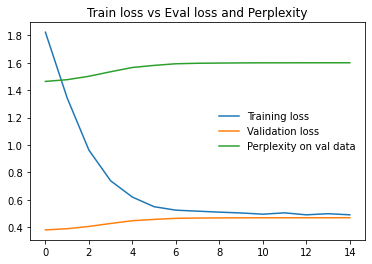

In [ ]:
import matplotlib.pyplot as plt

tr_los = np.array(train_loss)
ev_los = np.array(eval_loss)
per = np.array(perplexity)

plt.plot(tr_los, label='Training loss')
plt.plot(ev_los, label='Validation loss')
plt.plot(per, label='Perplexity on val data')

plt.legend(frameon=False)
plt.title('Train loss vs Eval loss and Perplexity')
plt.show()

In [ ]:
def generator(model, dataset_loader):
  
  model.eval()

  results = {"generated_summary": [], "golden_summary": []}

  with torch.no_grad():

    for idx, data_val in enumerate(dataset_loader):
      
      input_ids, source_mask, summary_ids, summary_mask = data_val 
      
      input_ids = input_ids.to(device, dtype = torch.long)
      source_mask = source_mask.to(device, dtype = torch.float)
      summary_ids = summary_ids.to(device, dtype = torch.long)

      generatation = model.generate(input_ids=input_ids,
                                    attention_mask=source_mask, 
                                    min_length=30, 
                                    max_length=300, 
                                    num_beams=1,
                                    repetition_penalty=2.5,
                                    eos_token_id = model.config.eos_token_id,               
                                    length_penalty=1.0, 
                                    early_stopping=True
                                    )

      for gen, sc in zip(generatation, summary_ids): # Taking whole document IDs and docode the summary

        gen_tokens_dec = tokenizer.decode(gen, skip_special_tokens=True, clean_up_tokenization_spaces=True)
        sc_tokens_dec = tokenizer.decode(sc, skip_special_tokens=True, clean_up_tokenization_spaces=True)

        results["generated_summary"].append(gen_tokens_dec)
        results["golden_summary"].append(sc_tokens_dec)

  return results


#### Loading Saved Model

In [ ]:
pretrained = False

if pretrained:    

    model = .... # first initialize the model and optimizer

    #optimizer = ... # optimizer then,
    infile = open(pcle,'rb')
    optimizer = pickle.load(infile)
    infile.close()

    checkpoint = torch.load(PATH)
    model.load_state_dict(checkpoint['model_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']

In [ ]:
%time results = generator(model, val_loader)

CPU times: user 23min 6s, sys: 50 s, total: 23min 56s
Wall time: 21min 3s


#### Visualizing examples

**Example 1**

In [ ]:
print("Actual summary:")
results['golden_summary'][0]

Actual summary:


'SAN DIEGO PADRES team notebook'

In [ ]:
print('Generated summary:')
results['generated_summary'][0]

Generated summary:


'So sayeth Padre general manager Kevin Towers. Less than two weeks after unofficially setting his starting rotation by trading for No. 1 Kevin Brown and re signing No. 5 Pete Smith, Towers stirred the pot Jan. 7 by signing Mark Langston to a minor league contract. But the Padres have no intention of having Langston pitch at Triple A Las Vegas. And neither does the 37 year old left hander. We didn t get him to pitch at Las Vegas, said GM Kevin Towers emphatically.'

**Example 2**

In [ ]:
Xtest_trial.iloc[10,:]['text']

'As the lights went down at the nearly sold out House of Blues on Saturday, Robert Johnson s 1936 Delta blues Cross Roads came up, and 19 year old Jake Bugg ambled onto the darkened stage with his two bandmates, greeted by shrieks from all sides.\n\nWith his fetching mop top and boyish charm, this JB comes off like the anti pop Justin Beiber, reviving rock n roll as sincere but sexy folk music for the long tailed digital age.\n\n Definitely not the radio, said 17 year old Stoneham resident Caroline Thompson when asked how she d learned about the English singer songwriter, whose 2012 debut topped the UK charts but never broke the US top 40. Instead, Thompson and two separately interviewed older male concertgoers credited music festivals. To promote his second album, Shangri La, Bugg has performed in Boston several times recently, at successively larger venues.\n\nAt the 2,400 capacity House of Blues, the bassist and drummer planted themselves at either end of the large stage and Bugg to

In [ ]:
print("Actual summary:")
results['golden_summary'][10]

Actual summary:


'As the lights went down at the nearly sold out House of Blues on Saturday, Robert Johnson s 1936 Delta blues Cross Roads came up, and 19 year old Jake Bugg ambled onto the darkened stage with his two bandmates, greeted by shrieks from all sides. With his fetching mop top and boyish charm, this JB comes off like the anti pop Justin Beiber, reviving rock n roll as sincere but sexy folk music for the long tailed digital age. To promote his second album, Shagri La, Bugg has performed in Boston several times recently, at successively larger venues. At the 2,400 capacity House of Blue'

In [ ]:
print('Generated summary:')
results['generated_summary'][10]

Generated summary:


'As the lights went down at the nearly sold out House of Blues on Saturday, Robert Johnson s 1936 Delta blues Cross Roads came up, and 19 year old Jake Bugg ambled onto the darkened stage with his two bandmates, greeted by shrieks from all sides. With his fetching mop top and boyish charm, this JB comes off like the anti pop Justin Beiber, reviving rock n roll as sincere but sexy folk music for the long tailed digital age. Definitely not the radio, said 17 year old Stoneham resident Caroline Thompson when asked how she d learned about the English singer songwriter, whose 2012 debut topped the UK charts but never broke the US top 40. Instead, Thompson and two separately interviewed older male concertgoers credited music festivals.'

**Example 3**

In [ ]:
Xtest_trial.iloc[3,:]['text']

'Remember when everyone on Earth was glued to Twitter and their TVs, of course as 33 Chilean miners were hoisted from captivity after 69 days underground? If you thought that story would top this week s Twitter trends chart, think again, pal.\n\nTurns out, nothing can top the trend power of Korean boy band Super Junior specifically the singer Kim Hee chul, whose name, you may have noticed, rarely left the top of the trending topics this week. With Bieber esque panache, Hee chul launched Super Junior to the top of this week s chart, leaving the Chilean miners down below too soon? at number two.\n\nAnd there s good news this week for tweeters who like their trends highbrow. News around the recently announced Nobel Prize winners continued to trend strongly for the second week in a row, moving the topic up from fourth to third.\n\nCurious about the rest of this week s top Twitter topics? Scroll on down to the complete chart below, which is compiled by our friends over at What The Trend. Be

In [ ]:
print("Actual summary:")
results['golden_summary'][3]

Actual summary:


'Check out the chart to find out what the world was talking about on Twitter this past week.'

In [ ]:
print('Generated summary:')
results['generated_summary'][3]

Generated summary:


'The trending topics on Twitter this week have barely topped the charts, but there s good news for those who like their tweets highbrow.'

**Example 4**

In [ ]:
Xtest_trial.iloc[2,:]['text']

'This story was reported by NICK CHARLES, AUSTIN EVANS FENNER AND SAMSON MULUGETA It was written by KAREN HUNTER\n\nTuesday, October 17th 1995, 4 20AM\n\nAs many black men marched on Washington yesterday, some New Yorkers spoke of their pride in the event and their disappointment in not being there, too.\n\n I felt like the only black person working, said Roderick Vinson, 38, of Harlem. That feeling made me sick to my stomach. I couldn t believe I missed one of the important events of my life. \n\nWinston Ford, 50, had to work, too. He makes his living selling incense and body oils in Brooklyn.\n\n I didn t have the finances to make the trip, he said. But my heart and soul is with them in Washington. \n\nFor HIV positive Sheldon Julius of Harlem, the Million Man March was a wakeup call. Long an absentee father, he called his 15 year old son Sunday night and for the first time ever told him that he loved him. The calling of the march made me realize my responsibility, he said.\n\nBut so

In [ ]:
print("Actual summary:")
results['golden_summary'][2]

Actual summary:


'As many black men marched on Washington yesterday, some New Yorkers spoke of their pride in the event and their disappointment in not being there, too. I felt like the only black person working, said Roderick Vinson, 38, of Harlem. That feeling made me sick to my stomach. I couldn t believe I missed one of the important events of my life. Winston Ford, 50, had to work, too. He makes his living selling'

In [ ]:
print('Generated summary:')
results['generated_summary'][2]

Generated summary:


'As many black men marched on Washington yesterday, some New Yorkers spoke of their pride in the event and their disappointment in not being there, too. I felt like the only black person working, said Roderick Vinson, 38, of Harlem. That feeling made me sick to my stomach. I couldn t believe I missed one of the important events of my life. Winston Ford, 50, had to work, too. He makes his living selling incense and body oils in Brooklyn. I didn t have the finances to make the trip, he said. But my heart and soul is with them in Washington.'

######Performance

In [ ]:
!pip3 install rouge
from rouge import Rouge

In [ ]:
!pip3 install rouge-score tqdm
from rouge_score import rouge_scorer, scoring

In [ ]:
from typing import Dict

def get_score(summaries) -> Dict:  
    
    src_labels = summaries['golden_summary']
    gen_summary = summaries['generated_summary']
    
    scorer = rouge_scorer.RougeScorer(['rouge1','rouge2','rougeL'], use_stemmer=True)
    aggregator = scoring.BootstrapAggregator()
    
    for src, gent in zip(src_labels, gen_summary):
        scores = scorer.score(gent, src)
        aggregator.add_scores(scores)
        
    results = aggregator.aggregate()
    return {key: val.mid.fmeasure for key, val in results.items()}

In [ ]:
get_score(results)

{'rouge1': 0.37475500865610795,
 'rouge2': 0.2654813985916763,
 'rougeL': 0.336889087504554}

In [ ]:
rouge = Rouge()

score = rouge.get_scores(results['generated_summary'], results['golden_summary'], avg=True)
{key: val['f'] for key, val in score.items()}

{'rouge-1': 0.3492512018706707,
 'rouge-2': 0.25526757621917745,
 'rouge-l': 0.3449526534575657}

##### Freezing layers

In [ ]:
model.decoder.block[11].requires_grad=True
model.decoder.block[4].requires_grad=True

for param model.parameters():
    param.requires_grad = False

In [ ]:
class T5Model(nn.Module):

  def __init__(self, t5, )

In [ ]:
class DictionaryDataset:
  def __init__(self, dataset=None):
    self.w2index = defaultdict(int)
    self.index2w = defaultdict(lambda: 'SOS')
    self.symbols = ['SOS','EOS','PAD']
    self.wcount = 3

    for i, s in enumerate(self.symbols):
      self.index2w[i] = s
    for i, s in enumerate(self.symbols):
      self.w2index[s] = i
      
    if dataset:
      for i, line in tqdm(enumerate(dataset)):
        self.word2index(line)

  def word2index(self, sentence):
    words = sentence.split()
    for word in words:
      if word not in self.w2index.keys():
        self.w2index[word] = self.wcount
        self.index2w[self.wcount] = word
        self.wcount +=1
    
  def encode_sequence(self, dataset):
    for i, line in tqdm(enumerate(dataset)):
      self.word2index(line)

  def decode_idx(self, idx):
    dec_words = []
    for i in idx:
      dec_words.append(self.index2w[i])
    return dec_words

![LSTM](https://drive.google.com/open?id=19pYBGaKGx2wTHjDC3QLMkpr5HDqTPbb6)

![Seq2SeqWithAttention](https://drive.google.com/open?id=1QDLNN0XQ0TfeA-nyAGBhG3YgwAX0bPQU)

You should use the same number of layers, for encoder and decoder
shape for inputs is (batch size, sequence length), (batch size, 1) respectively.


In [ ]:
class Encoder(nn.Module):
  def __init__(self,input_size, embed_size, num_hidden, batch_size, num_layers=3, dropout = 0.1):
    super(Encoder, self).__init__()
    self.num_hidden = num_hidden
    self.num_layers = num_layers
    self.input_size = input_size
    self.batch_size = batch_size

    self.embed = nn.Embedding(input_size, embed_size)
    self.lstm = nn.LSTM(input_size=embed_size, hidden_size=num_hidden,num_layers = num_layers, dropout=(0 if num_layers ==2 else dropout))

  def init_hidden(self):
     # The axes semantics are (num_layers, minibatch_size, hidden_dim)
    return (torch.zeros(self.num_layers, self.batch_size, self.num_hidden), torch.zeros(self.num_layers, self.batch_size, self.num_hidden))
  def forward(self, input, hidden):
    # input (batch size, sequence length)
    embedding = self.embed(input)
    #print(embedding.shape)
    embed_out = embedding.transpose(0,1)
    print(embed_out.shape)
    lstm_out, hidden = self.lstm(embed_out, hidden)

    # The shape of lstm_out is (seq_len, batch_size, num_hiddens).
    # state contains the hidden state and the memory cell
    # of the last time step, the shape is (num_layers, batch_size, num_hiddens)
    #lstout is (seq_length, batch_size, num_hiddens)
    return lstm_out, hidden

In [ ]:
encoder = Encoder(input_size =10, embed_size=8, num_hidden=16, batch_size=4)
X = torch.zeros((4, 7),dtype=torch.long)
hidden = encoder.init_hidden()
output, hidden = encoder(X, hidden)

torch.Size([7, 4, 8])


In [ ]:
hidden[0].shape

torch.Size([3, 4, 16])

In [ ]:
output.shape

torch.Size([7, 4, 16])

In [ ]:
class Attention(nn.Module):
  def __init__(self, hidden_size, method='dot'):
    super(Attention, self).__init__()
    self.method = method
    self.hidden_size = hidden_size
  def dot_score(self, hidden, encoder_output):
    return torch.sum(hidden * encoder_output, dim=2)

  def forward(self, hidden, encoder_output):
    att_prod = self.dot_score(hidden, encoder_output)
    attn_weights = att_prod.t()
    return F.softmax(attn_weights, dim=1).unsqueeze(1)



In [ ]:
class DecoderWithAtt(nn.Module):
  def __init__(self, embed_size_in, num_hidden, output_size, att_method=None, num_layers = 3):
    super(DecoderWithAtt, self).__init__()
    self.num_layers = num_layers
    self.num_hidden = num_hidden
    self.output_size = output_size
    self.att_method = att_method

    self.emb = nn.Embedding(embed_size_in, num_hidden)
    self.lstm = nn.LSTM(input_size=num_hidden, hidden_size=num_hidden, num_layers = num_layers)
    self.con_ln = nn.Linear(num_hidden * 2, num_hidden)
    self.drop = nn.Dropout(p=0.2)
    self.fc  = nn.Linear(self.num_hidden, self.output_size)
    self.attention = Attention(att_method, num_hidden)

  def forward(self, prev_hidden, target_input, enconder_outputs):
    embed_out = self.emb(target_input).transpose(0,1)
    embed_out = self.drop(embed_out)
    print('embed out >>>', embed_out.shape)
    output, hidden = self.lstm(embed_out, prev_hidden) # shape (1, batch_size, hidden_size), 1 for one time step word 
    print('lstm out >>>', output.shape)
    print('hidden out >>>', hidden[0].shape)

    attent_weights = self.attention(output, enconder_outputs) # (att out shape: batch_size, 1, max_length), enc in shape: (max_length, batch_size, hidden_size)
    print('attent_weights out >>>', attent_weights.shape)
    print('enconder_outputs >>>', enconder_outputs.shape)

    context = torch.bmm(attent_weights, enconder_outputs.transpose(0,1))
    print('context out >>>', context.shape)
    cont_dec_out = torch.cat((context, output.transpose(0,1)), 1)
    print('to linear out >>>', cont_dec_out.shape)
    cont_dec_out = cont_dec_out.view(cont_dec_out.shape[0], -1)
    concat_out = self.con_ln(cont_dec_out)
    concat_out = torch.tanh(concat_out)

    out = self.fc(concat_out)
    out = F.softmax(out, dim=1)

    return out, hidden

In [ ]:
decoder = DecoderWithAtt(10,16,2)

In [ ]:
x = torch.zeros((4, 1),dtype=torch.long)
out, hidden = decoder(hidden, x, output)

embed out >>> torch.Size([1, 4, 16])
lstm out >>> torch.Size([1, 4, 16])
hidden out >>> torch.Size([3, 4, 16])
attent_weights out >>> torch.Size([4, 1, 7])
enconder_outputs >>> torch.Size([7, 4, 16])
context out >>> torch.Size([4, 1, 16])
to linear out >>> torch.Size([4, 2, 16])


In [ ]:
out.shape

torch.Size([4, 2])

In [ ]:
hidden[0].shape

torch.Size([3, 4, 16])